# Postprocess Delta Analysis

We will now look at the output of Delta. For package info, please refer to the Project2A Notebook.

You can also find a lot of extra info in the Delta documentation [here](https://delta.readthedocs.io/en/latest/usage/analysis.html)

---

## Import packages

Before starting the code we need to import all the required packages.

We use a number of important Python packages:
- [Numpy](https://numpy.org): Goto package for vector/matrix based calculations (heavily inspired by Matlab)
- [Pandas](https://pandas.pydata.org): Goto package for handling data tables (heavily inspired by R) 
- [Scipy](https://scipy.org): Numpy extensions for statistics, image analysis, and more
- [Scikit-image (skimage)](https://scikit-image.org): Goto package for image analysis
- [Matplotlib](https://matplotlib.org): Goto package for plotting data
- [Napari](https://napari.org): GUI based interactive image viewer
- [pathlib](https://docs.python.org/3/library/pathlib.html): Path handling made easy
- [pickle](https://docs.python.org/3/library/pickle.html): Read pkl file format
- [delta](https://delta.readthedocs.io/en/latest/usage/analysis.html): Delta pipeline

In [1]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns

import pathlib
import tifffile
import pickle

from skimage.measure import regionprops

import napari
from napari.utils.notebook_display import nbscreenshot

import delta

---

## Setup Folders
As always we start with specifying the data paths:

In [2]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'I2ICourse', 'Project2B')
processed_dir = proj_dir / 'ProcessedData'
image_dir = proj_dir / 'RawData'

In [3]:
def to_str(posixpath):
    return str(posixpath.resolve())    

---

## Load Data
We can now load the data again. See [here](https://delta.readthedocs.io/en/latest/usage/analysis.html) for detailed instructions.
To load all data we can use the following command:

In [4]:
delta.config.load_config(to_str(proj_dir / 'config_2D_local.json'))
reader = delta.utilities.xpreader(image_dir, 
                                    prototype = 'Pos%03i_Frm%03i_Ch%02i.tif',
                                    fileorder = 'ptc',
                                    filenamesindexing=1
                                    )
processor = delta.pipeline.Pipeline(reader, reload=True, resfolder=to_str(processed_dir))

Loading configuration from: /Users/simonvanvliet/I2ICourse/Project2B/config_2D_local.json


We can the access the position of choice as:

In [5]:
pos = processor.positions[0]

Instead we can also just directly load a single position:

In [6]:
#find all position .pkl outputs:
file_dirs = sorted(processed_dir.glob('*.pkl'))
print(file_dirs)
# this loads the processed data
pos_name = to_str(file_dirs[0])
pos = delta.pipeline.Position(None,None,None)
pos.load(pos_name)

[PosixPath('/Users/simonvanvliet/I2ICourse/Project2B/ProcessedData/Position000000.pkl'), PosixPath('/Users/simonvanvliet/I2ICourse/Project2B/ProcessedData/Position000000_df.pkl'), PosixPath('/Users/simonvanvliet/I2ICourse/Project2B/ProcessedData/Position000000_updated_lin.pkl')]


---

## Visualize Segmentation with Napari

We can add the image data and segmentation data to Napari to visually inspect them:

In [7]:
imstack = np.stack(pos.rois[0].img_stack, axis=0) #load image data from position file
labelstack = np.stack(pos.rois[0].label_stack, axis=0) #load label data from position file

viewer = napari.view_image(imstack)
viewer.add_labels(labelstack)
viewer.show()

---

## Inspect Cell Tracking Data

All tracking info is stored in the [lineage object](https://delta.readthedocs.io/en/latest/usage/utils_desc.html#lineage). 

> **Exercise** 
> 
> Have a look the lineage class documentation and check what kind of information is stored

We can also use the `keys` method to see what information is stored in the lineage object:

In [8]:
lin = pos.rois[0].lineage #get lineage for first region of interest (whole frame)
cell_0 = lin.cells[0] #lineage info of first cell
print('info stored in linegae object =', cell_0.keys()) 


info stored in linegae object = dict_keys(['id', 'mother', 'frames', 'daughters', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'fluo1'])


Next we will plot the length of the cells present in the first frame

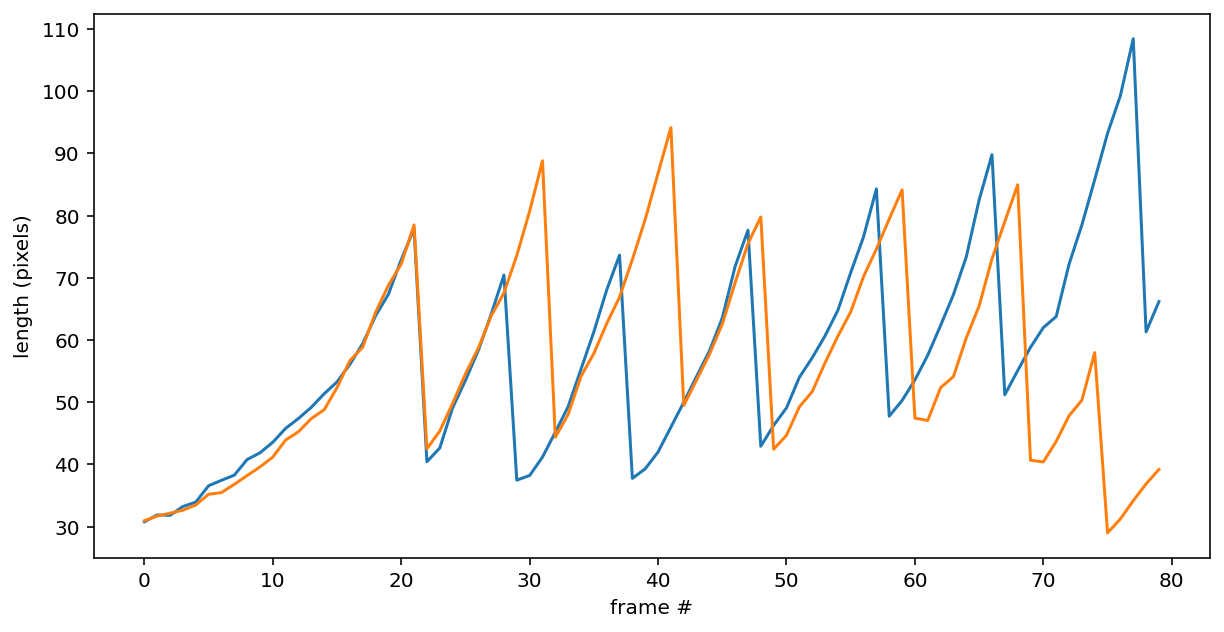

In [9]:
first_cells = lin.cellnumbers[0]
for cell_id in first_cells:
    cell = lin.cells[cell_id]
    plt.plot(cell['frames'],cell['length'])
plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()    

---

## Convert Tracking Data to Standard Format

As you can clearly see from the saw-tooth pattern of cell length, a cell lineage in Delta is defined in a bit of a weird way as it continues across cell divisions. More commonly a cell lineage is defined to start at cell birth and stop and cell division. 

As a first step we thus have to split these lineages into segments.
Below we give a function that does this (no need to try to understand this code for now).

In [10]:
def split_lineages(lin):
    #first we give each sublineage a unique id
    unique_count = 0 
    #loop delta lineages
    for cell in lin.cells:

        ## create sublineage ID
        #find division events
        div_event = np.array([d is not None for d in cell['daughters']])
        #cumulative number of divisions gives a unique nr to each segment
        sublin_id = np.cumsum(div_event) 
        #now assign unique number accross all cell lineages
        unique_id = sublin_id + unique_count #unique cells id
        
        #update unique_count 
        unique_count += (np.sum(div_event) + 1)
        
        #init output fields
        empty_list = np.full_like(sublin_id, -1).tolist()
        cell['lin_id'] = empty_list
        cell['sublin_idx'] = empty_list
        cell['mother_lin_id'] = empty_list
        cell['d1_lin_id'] = empty_list
        cell['d2_lin_id'] = empty_list
        
        ##now we have to connect lineages together
        #find mother cell and birth frame
        mom_idx = cell['mother'] #this is mother of delta lineage 
        birth_frm = cell['frames'][0]        
        if mom_idx is not None:
            mom = lin.cells[mom_idx] #get properties of mom
            
            try:
                ## find unique cell id of the proper sub-segment in the mom lineage
                div_frm = mom['frames'].index(birth_frm-1)
                mom_lin_id = mom['lin_id'][div_frm] #this is proper unique lin id of mom
                
                ## we now want to add info of this d2 offspring to mother
                #we extract frames of current segment in mom (between current and prev division)
                div_events_mom = np.nonzero(np.array(mom['daughters'])[0:birth_frm])[0]
                start_idx = div_events_mom[-1] if div_events_mom.size > 0 else 0
                
                #assign d2 lin number to correct frames
                d2_temp = np.array(mom['d2_lin_id'])
                d2_temp[start_idx:birth_frm] = unique_count                
                mom['d2_lin_id'] = d2_temp.tolist()
                
            except:
                mom_lin_id = -1
        else:
            #no mom found (first cell)
             mom_lin_id = -1   
                    
        
        ## add mother info
        #the id of mother is the id of prev segment
        mother_lin_id = unique_id.copy() - 1
        #except for first segment, there we use the lin_index of mother we found above
        mother_lin_id[sublin_id==0] = mom_lin_id
        
        #add d1 offspring number to linage 
        #this is simply next segment
        d1_lin_id = unique_id.copy() + 1
        #except for last segment, this does not have d1 offspring 
        d1_lin_id[d1_lin_id==d1_lin_id[-1]] = -1

        #now we assign properties to cell
        cell['sublin_idx'] = sublin_id.tolist()
        cell['lin_id'] = unique_id.tolist()
        cell['mother_lin_id'] = mother_lin_id.tolist()
        cell['d1_lin_id'] = d1_lin_id.tolist()
        
    return None #lin is updated in place

We know apply this function, and can see we have added some new items to the linage object.

Most importantly: the property `lin_id` now gives a unique number to each and every cell.

In [11]:
split_lineages(lin) #call split lin function
print('info stored in linegae object =', lin.cells[0].keys()) 

info stored in linegae object = dict_keys(['id', 'mother', 'frames', 'daughters', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'fluo1', 'lin_id', 'sublin_idx', 'mother_lin_id', 'd1_lin_id', 'd2_lin_id'])


We can use this plot each lineage separately:

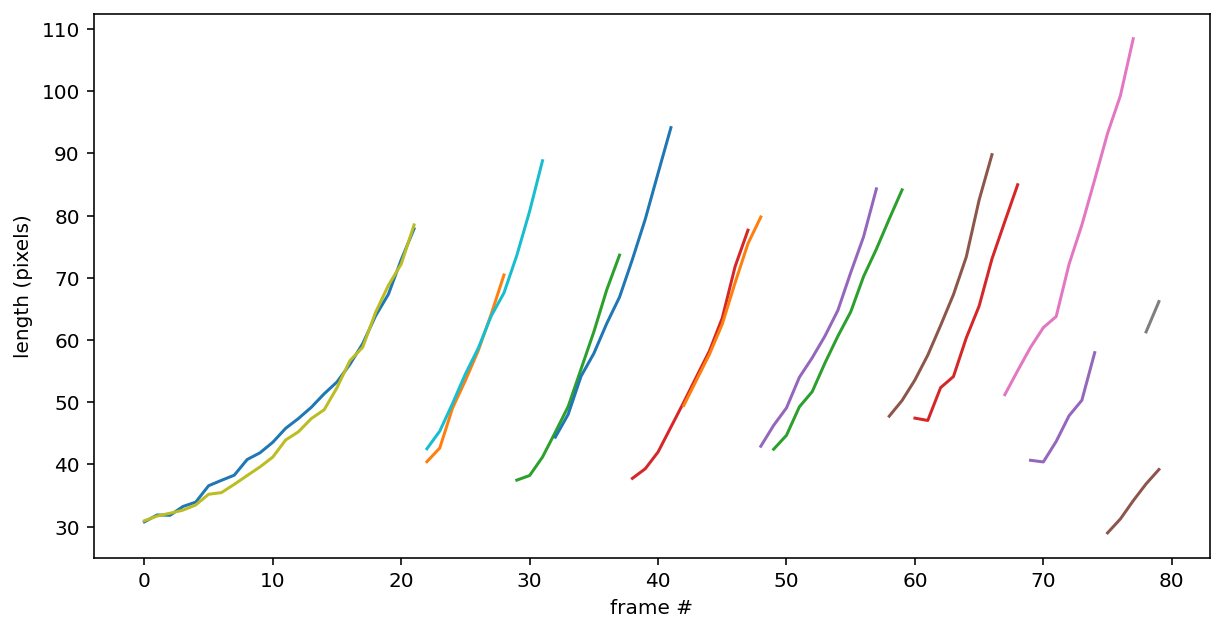

In [12]:
first_cells = lin.cellnumbers[0]
for cell_id in first_cells:
    #current cell lineage
    cell = lin.cells[cell_id]
    
    #convert lists to numpy arrays for easier manipulation
    lin_id_vec = np.array(cell['lin_id'])
    lin_frames = np.array(cell['frames'])
    lin_length = np.array(cell['length'])
    
    #loop over all sublineages 
    for lin_id in np.unique(lin_id_vec):
        #find frames of current sub-lin
        curr_frames = lin_id_vec==lin_id
        plt.plot(lin_frames[curr_frames],lin_length[curr_frames])
plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()   

---

## Add Positional Information

If you have another look at the lineage object you can see it does not contain information on the location of cells. We add a function below to do this.

In [13]:
def add_segment_info(lin, label_stack):
    #lin: delta linage object
    #label_stack: list of label images = pos.rois[0].label_stack
   
    #initialize new property keys:
    for cells in lin.cells:
        cells.setdefault('x_pos',[])
        cells.setdefault('y_pos',[])
   
    #loop frames
    for label_im in label_stack:
        #get region properties
        rp_list = regionprops(label_im)
        
        #assign cell phenotypes
        for idx, rp in enumerate(rp_list):
            #get lineage number of cell (note labels are 1 based, cell lineages are 0 based!)
            cell_idx = rp.label-1
            #assign phenotypes
            lin.cells[cell_idx]['x_pos'].append(rp.centroid[1]) #order in centroid is (y,x)
            lin.cells[cell_idx]['y_pos'].append(rp.centroid[0]) #order in centroid is (y,x)
                    
    return None

We know apply this function, and can see we have added some new items to the linage object:

In [14]:
add_segment_info(lin, pos.rois[0].label_stack) #call split lin function
print('info stored in linegae object =', lin.cells[0].keys()) 

info stored in linegae object = dict_keys(['id', 'mother', 'frames', 'daughters', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'fluo1', 'lin_id', 'sublin_idx', 'mother_lin_id', 'd1_lin_id', 'd2_lin_id', 'x_pos', 'y_pos'])


It is always good to check things visually. Below we define a function that can be used to plot any cell property of choice as a spatial map:

In [15]:
def plot_spatial_map(pos, lin, property, frame=-1, axis=None):
   #pos: delta position object
   #lin: delta linage object
   #property: key of cell property contained in lineage object
   #frame: frame to show, if not specified last one is chosen
   #axis: axis to add plot to, if not specified new one is made
   
   #create color map where Nan is shown as black  
   colMap = cm.get_cmap("viridis").copy()
   colMap.set_bad(color='black')
   
   #get frame
   frame = len(pos.rois[0].label_stack)-1 if frame==-1 else frame

   # get label image:
   labels = pos.rois[0].label_stack[frame]

   spatial_map = np.full(labels.shape, np.nan)

   # Go over cells in selected frame:
   for cnb in lin.cellnumbers[frame]:
   
      #convert to numpy to allow for advanced indexing
      cell_frames = np.array(lin.cells[cnb]['frames'])
      cell_prop = np.array(lin.cells[cnb][property])
   
      #frame index      
      fr_idx = cell_frames==frame
      cell_prop = cell_prop[fr_idx]
      
      #assign cells mask area the phenotype of choice
      spatial_map[labels==cnb+1] = cell_prop

   #create new axis if needed
   if axis is None:
      fig, axis = plt.subplots()
   
   #make plot
   axis.imshow(spatial_map, cmap=colMap)
   axis.set_xlabel('x-pos') 
   axis.set_ylabel('y-pos') 
   axis.set_title(property)
   
   return None

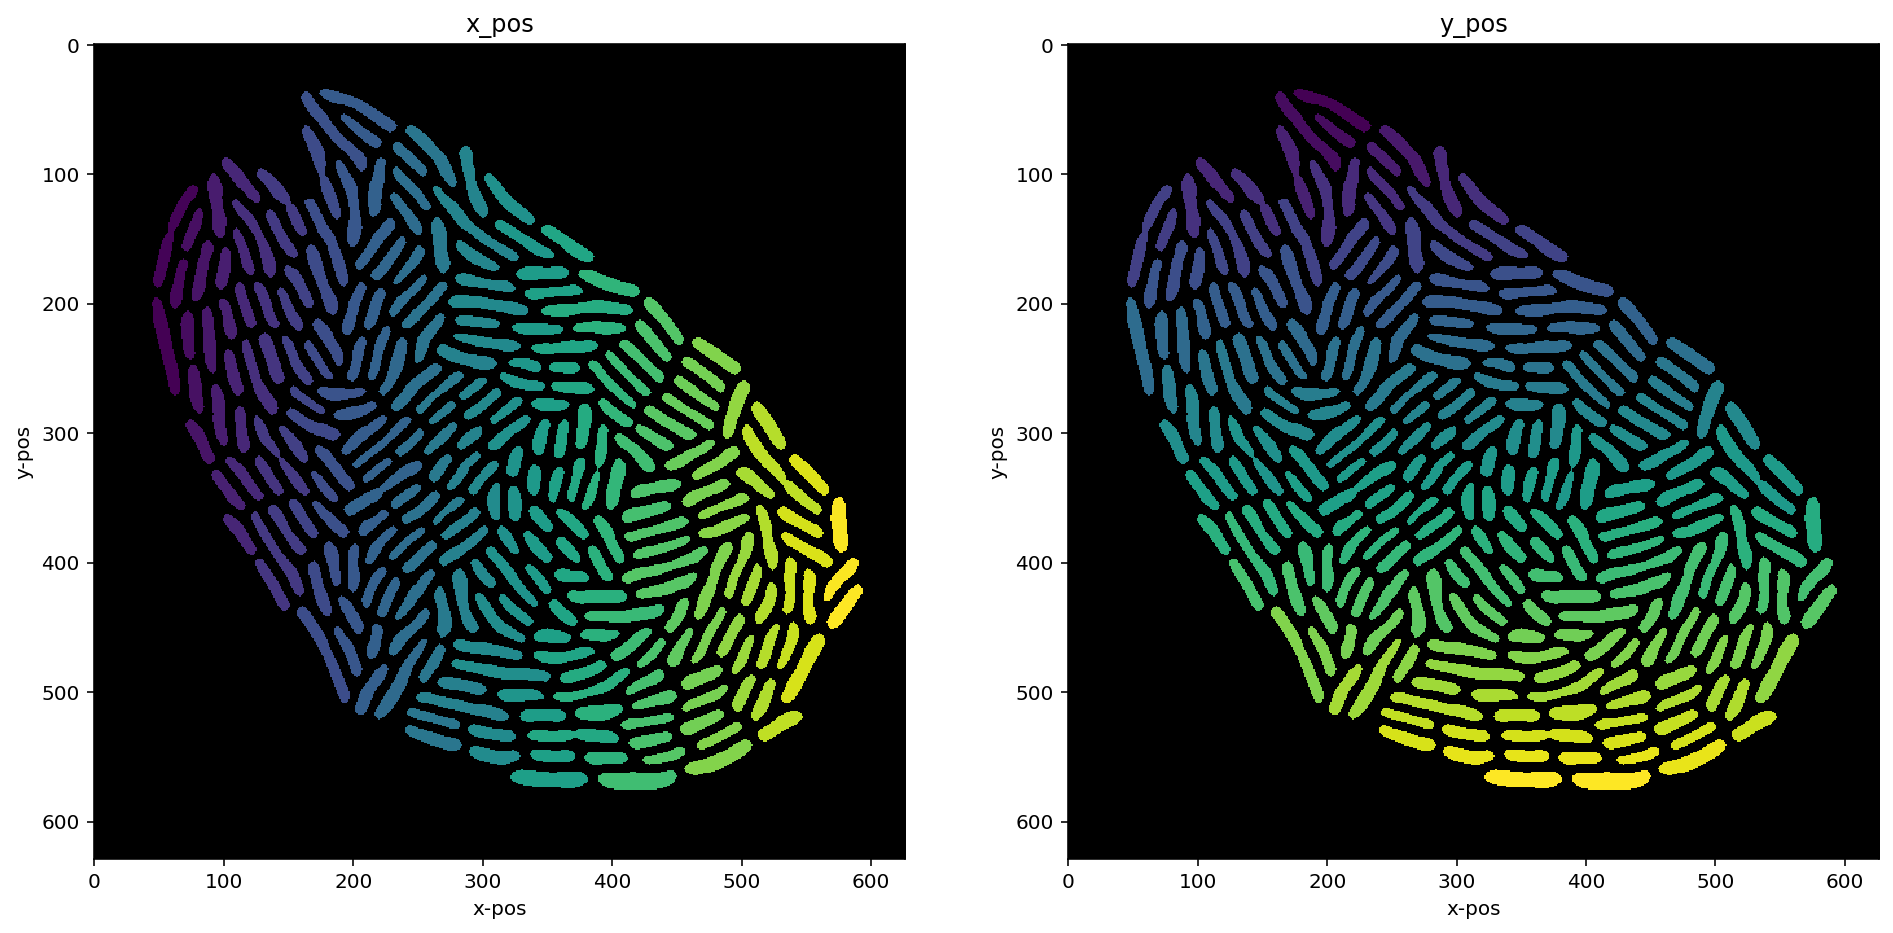

In [16]:
fig, axs = plt.subplots(1,2,figsize=(16,24))
plot_spatial_map(pos, lin, 'x_pos', axis=axs[0])
plot_spatial_map(pos, lin, 'y_pos', frame=-1, axis=axs[1])

### *Technical note*

*The phase contrast images are stored within the delta position object.  
You can access them with: `pos.rois[0].img_stack` which returns a list of 2D images, so to get the image from frame `f` you can use: `ph_im = pos.rois[0].img_stack[f]`.*

*The fluorescent images are not stored however, and you will need to read them from disk if you ever need them (e.g. if you want to do proper shading & background corrections before extracting fluorescent intensities for precise quantification).*

*You can use Delta's [`xpreader`](https://delta.readthedocs.io/en/latest/usage/utils_desc.html#the-xpreader-class) class to find the file name of the pictures: `tiff_name = reader.getfilenamefromprototype(pos_idx,ch_idx,frm_idx)`.*  
Then you can read the image file using `tifffile.imread(tiff_name)`*

*For now we just use Delta's default fluorescent values, but we provide a modified version of the `add_segment_info` function below (called `add_cell_info`) that you could modify in the future incase you need to implement proper image corrections.*

In [17]:
def add_cell_info(lin, label_stack, reader):
    #lin: delta linage object
    #label_stack: list of label images = pos.rois[0].label_stack
    #reader: delta_xp reader object
    
    #get number of channels
    n_ch = reader.channels
    n_fluor = n_ch - 1
    
    #create channel names
    ch_names_av = ['fluor%i' % ch for ch in range(n_ch)]
    ch_names_cor = ['cor_fluor%i' % ch for ch in range(n_ch)]
    ch_names_tot = ['tot_fluor%i' % ch for ch in range(n_ch)]

    
    #initialize new property keys:
    for cells in lin.cells:
        cells.setdefault('x_pos',[])
        cells.setdefault('y_pos',[])
        for ch in range(n_fluor):
            cells.setdefault(ch_names_av[ch],[])
            cells.setdefault(ch_names_tot[ch],[])
    
    #loop frames
    for fr, label_im in enumerate(label_stack):
        #load fluorescent images
        fluor_im_list = [] 
        for ch in range(n_fluor):
            #read image
            tiff_name = reader.getfilenamefromprototype(0,ch+1,fr) 
            fluor_im = tifffile.imread(tiff_name)
            # 
            # insert code here for shading correction etc.
            # fluor_im = function_for_shading_correction(fluor_im)
            # this code would do something like: corrected_im = fluor_im / shading_im
            # where shading image is an image taken with an homogenous sample. It's intensity thus reflects the intensity of the light field
            #
            fluor_im_list.append(fluor_im)
        
        #combine in multichannel image
        multi_ch = np.stack(fluor_im_list, axis=-1)
        
        #get region properties
        rp_list = regionprops(label_im, intensity_image=multi_ch)
        
        #assign cell phenotypes
        for idx, rp in enumerate(rp_list):
            #get lineage number of cell (note labels are 1 based, cell lineages are 0 based!)
            cell_idx = rp.label-1
            
            #assign phenotypes
            #for example we can add position info, or any other region props property
            lin.cells[cell_idx]['x_pos'].append(rp.centroid[1]) #order in centroid is (y,x)
            lin.cells[cell_idx]['y_pos'].append(rp.centroid[0]) #order in centroid is (y,x)
            
            #now assign fluorescent values
            for ch in range(n_fluor):
                #get mean fluorescent intensity
                mean_I = rp.intensity_mean[ch]
                #get total fluorescent intensity
                tot_I = rp.intensity_mean[ch] * rp.num_pixels
                
                # insert code here for background correction
                # bg_signal = function_to_extract_bg_intensity(fluor_im, label_im)
                #option 1: simple substraction (works best if bg_signal-dark_signal is very low)
                # corr_I = mean_I - bg_signal 
                #option 2: fold-change ratio (works best when bg_signal-dark_signal is not too close to 0)
                # corr_I = (mean_I - dark_signal) / (bg_signal - dark_signal) 
                # the dark_signal is the median intensity of image taken with closed shutter
                # the bg_signal is the median intensity in pixels that do not belong to cells
            
                #store values
                lin.cells[cell_idx][ch_names_av[ch]].append(mean_I) #mean intensity
                lin.cells[cell_idx][ch_names_tot[ch]].append(tot_I) #total intensity
                #lin.cells[cell_idx][ch_names_cor[ch]].append(corr_I) #corrected mean intensity
                    
    return None

We can then convert the list of dictonaries to a pandas data frame:

---

## Convert to Pandas dataframe

Now that we have all the important cell properties we can convert the Delta output to a Pandas dataframe. We provide a function for this below:

In [18]:
def lin_to_df(lin):
    #find vector based data (only vector based data is compatible with dataframe)
    vector_data = []
    [vector_data.append(key) for key in lin.cells[0].keys() if isinstance(lin.cells[0][key], list)]
    #create data frame
    df = pd.DataFrame(lin.cells) 
    #this creates nested dataframe, we need to explode time into separate rows:
    df = df.explode(vector_data)
    #and reindex
    df = df.reset_index(drop=True)

    return df

In [19]:
df = lin_to_df(lin)
df.head()

,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,fluo1,lin_id,sublin_idx,mother_lin_id,d1_lin_id,d2_lin_id,x_pos,y_pos
0,0,NaN,0,None,"[250, 310]","[236, 298]",,30.766232,11.088337,267.0,30,216.422819,0,0,-1,1,23,305.362416,243.97651
1,0,NaN,1,None,"[253, 311]","[237, 297]",,31.876179,10.988653,273.5,27,234.334426,0,0,-1,1,23,304.872131,245.321311
2,0,NaN,2,None,"[261, 310]","[246, 295]",,31.819805,10.606601,276.0,30,235.65798,0,0,-1,1,23,303.0,253.693811
3,0,NaN,3,None,"[263, 306]","[248, 291]",,33.234016,11.313707,304.5,27,251.801187,0,0,-1,1,23,299.240356,255.436202
4,0,NaN,4,None,"[263, 304]","[247, 287]",,33.941124,11.313707,314.5,31,244.034483,0,0,-1,1,23,296.017241,254.451149


---

## All-in-one processing

For future use, we provide here a single wrapper function that takes as entry a delta position object and outputs a Pandas dataframe by successively calling the functions we defined above.

In [20]:
def delta_to_df(pos, reader=None):
    
    lin = pos.rois[0].lineage
    
    #split lineages:
    split_lineages(lin)
    
    #add segment info
    add_segment_info(lin, pos.rois[0].label_stack)
    
    #alternatively you can the add_cell_info function to include proper image correction
    #add_cell_info(lin, pos.rois[0].label_stack, reader)
    
    #convert to pandas dataframe
    df = lin_to_df(lin)
   
    return df

In [21]:
#let's first reload the position
pos = delta.pipeline.Position(None,None,None)
pos.load(pos_name)

df = delta_to_df(pos)
df.head(n=30)

,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,fluo1,lin_id,sublin_idx,mother_lin_id,d1_lin_id,d2_lin_id,x_pos,y_pos
0,0,NaN,0,None,"[250, 310]","[236, 298]",,30.766232,11.088337,267.0,30,216.422819,0,0,-1,1,23,305.362416,243.97651
1,0,NaN,1,None,"[253, 311]","[237, 297]",,31.876179,10.988653,273.5,27,234.334426,0,0,-1,1,23,304.872131,245.321311
2,0,NaN,2,None,"[261, 310]","[246, 295]",,31.819805,10.606601,276.0,30,235.65798,0,0,-1,1,23,303.0,253.693811
3,0,NaN,3,None,"[263, 306]","[248, 291]",,33.234016,11.313707,304.5,27,251.801187,0,0,-1,1,23,299.240356,255.436202
4,0,NaN,4,None,"[263, 304]","[247, 287]",,33.941124,11.313707,314.5,31,244.034483,0,0,-1,1,23,296.017241,254.451149
5,0,NaN,5,None,"[261, 304]","[246, 284]",,36.573315,11.401754,327.5,34,255.393939,0,0,-1,1,23,295.068871,253.482094
6,0,NaN,6,None,"[267, 305]","[252, 285]",,37.44136,11.257707,341.5,35,246.783069,0,0,-1,1,23,294.664021,258.902116
7,0,NaN,7,None,"[272, 307]","[256, 285]",,38.269344,11.229179,349.5,42,274.351421,0,0,-1,1,23,296.069767,263.374677
8,0,NaN,8,None,"[268, 309]","[250, 284]",,40.78558,11.266735,366.5,41,269.231527,0,0,-1,1,23,297.133005,258.623153
9,0,NaN,9,None,"[275, 307]","[257, 283]",,41.866165,11.421289,378.0,49,283.377088,0,0,-1,1,23,295.455847,265.315036


---

## File Saving
This would be a good time to save your data.  
You can save the position file using `pos.save(filename=filename, save_format='pickle')`. We won't do this now as we do not want to accidentally corrupt our data.

Instead we just save the dataframe:

In [22]:
save_name = processed_dir / pos_name.replace('.pkl','_df.pkl')
df.to_pickle(save_name)

And we save the updated lineage info:


In [23]:
save_name = processed_dir / pos_name.replace('.pkl','_updated_lin.pkl')
filehandler = open(save_name, 'wb') 
pickle.dump(lin, filehandler)

---

## Check Tracking with Napari

Now that we have the dataframe we can add the trackign info to Napari to check it visually.

For that we use the Napari [tracks layer](https://napari.org/howtos/layers/tracks.html).  
To use it we need to specify tracking data in a specific format  (see documentation above):

In [24]:
#create matrix with lin_id, and (t,x,y) coordinates
lin_data = np.vstack([df["lin_id"].to_numpy(dtype=int), 
                      df["frames"].to_numpy(dtype=int), 
                      df["y_pos"].to_numpy(dtype=int), 
                      df["x_pos"].to_numpy(dtype=int)]).T
lin_data.shape

(3273, 4)

In [25]:
#create dictionary that link lin_id of cell to lin_id of mother 
lin_id = df["lin_id"].to_numpy(dtype=int)
mom_id = df["mother_lin_id"].to_numpy(dtype=int)

#lin_id is a vector that contains many duplicate entries, we remove them using np.unique:
lin_set, idx_set = np.unique(lin_id, return_index=True)
mom_set = mom_id[idx_set]

#init graph dictionary
graph = {}
for linnum, mom in zip(lin_set, mom_set):
    if mom >= 0:
        graph[linnum] = mom

In [26]:
#add tracks to viewer
viewer.add_tracks(lin_data, name='Tracks', graph=graph)
viewer.show()

---

## Next Step: Explore data

**Before the next step the Tutors will give an introduction, if you are ready for this step please let them know!**

We continue in the next notebook `3_explore_data_delta`